In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
def extract_category_numbers(category_str):
    total_pattern = r'(\w+.*?)\s*\((\d+)'
    details_pattern = r'destroyed:\s*(\d+),\s*damaged:\s*(\d+),\s*abandoned:\s*(\d+),\s*captured:\s*(\d+)'
    
    total_match = re.search(total_pattern, category_str)
    details_match = re.search(details_pattern, category_str)
    
    if not total_match or not details_match:
        return None, 0, 0, 0, 0, 0
    
    category = total_match.group(1).strip()
    total = int(total_match.group(2))
    destroyed = int(details_match.group(1))
    damaged = int(details_match.group(2))
    abandoned = int(details_match.group(3))
    captured = int(details_match.group(4))
    
    return category, total, destroyed, damaged, abandoned, captured

In [ ]:
def extract_vehicles(description):
    #Pattern for finding quantity and type of vehicle
    vehicle_pattern = r'(\d+)\s+(.*?):'
    status_pattern = r'\(\s*(\d+),\s*(destroyed|damaged|abandoned|captured)(?:\s+and\s+(destroyed|damaged|abandoned|captured))?\s*\)'
    
    vehicle_match = re.search(vehicle_pattern, description)
    if not vehicle_match:
        return None, 0, {}
    
    vehicle_type = vehicle_match.group(2).strip()
    vehicle_count = int(vehicle_match.group(1))
    
    status_matches = re.findall(status_pattern, description)
    status_counts = {'destroyed': 0, 'damaged': 0, 'abandoned': 0, 'captured': 0}
    
    for match in status_matches:
        count = int(match[0])
        primary_status = match[1]
        status_counts[primary_status] += count
        
        #If it has secondary status (e.g. "damaged and abandoned")
        if match[2]:
            secondary_status = match[2]
            #Since we already counted the vehicle in primary status, we do not add it back to the total.
            status_counts[secondary_status] += count
    
    return vehicle_type, vehicle_count, status_counts

In [ ]:
def process_csv(file_path, side):
    df = pd.read_csv(file_path)
    
    processed_data = []
    
    for _, row in df.iterrows():
        category_str = row['Category']
        description = row['Description']
        
        category, total, destroyed, damaged, abandoned, captured = extract_category_numbers(category_str)
        if not category:
            continue
            
        vehicle_type, vehicle_count, status_counts = extract_vehicles(description)
        if not vehicle_type:
            continue
            
        processed_data.append({
            'side': side,
            'category': category,
            'category_total': total,
            'category_destroyed': destroyed,
            'category_damaged': damaged,
            'category_abandoned': abandoned,
            'category_captured': captured,
            'vehicle_type': vehicle_type,
            'vehicle_count': vehicle_count,
            'vehicle_destroyed': status_counts['destroyed'],
            'vehicle_damaged': status_counts['damaged'],
            'vehicle_abandoned': status_counts['abandoned'],
            'vehicle_captured': status_counts['captured']
        })
    
    return pd.DataFrame(processed_data)

In [ ]:
russian_losses = process_csv('data/russian_losses.csv', 'Russian')
ukrainian_losses = process_csv('data/ukrainian_losses.csv', 'Ukrainian')


In [ ]:
combined_df = pd.concat([russian_losses, ukrainian_losses])

In [ ]:
#Analysis 1: Total loss comparison by category between Russia and Ukraine
def analyze_total_losses_by_category():
    category_totals = combined_df.groupby(['side', 'category'])['vehicle_count'].sum().reset_index()
    
    pivot_df = category_totals.pivot(index='category', columns='side', values='vehicle_count').fillna(0)
    
    plt.figure(figsize=(14, 8))
    pivot_df.plot(kind='bar', figsize=(14, 8))
    plt.title('Comparison of Total Losses by Category between Russia and Ukraine')
    plt.xlabel('Category')
    plt.ylabel('Number of Vehicles')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('images/total_losses_by_category.png')
    
    return pivot_df

In [ ]:
#Analysis 2: Distribution of loss statuses (destroyed, damaged, etc.) for each side
def analyze_loss_status_distribution():
    russian_status = {
        'Destroyed': russian_losses['vehicle_destroyed'].sum(),
        'Damaged': russian_losses['vehicle_damaged'].sum(),
        'Abandoned': russian_losses['vehicle_abandoned'].sum(),
        'Captured': russian_losses['vehicle_captured'].sum()
    }
    
    ukrainian_status = {
        'Destroyed': ukrainian_losses['vehicle_destroyed'].sum(),
        'Damaged': ukrainian_losses['vehicle_damaged'].sum(),
        'Abandoned': ukrainian_losses['vehicle_abandoned'].sum(),
        'Captured': ukrainian_losses['vehicle_captured'].sum()
    }
    
    status_df = pd.DataFrame({
        'Russian': russian_status,
        'Ukrainian': ukrainian_status
    })
    
    plt.figure(figsize=(12, 8))
    status_df.plot(kind='bar', figsize=(12, 8))
    plt.title('Loss Status Distribution for Russian and Ukrainian Vehicles')
    plt.xlabel('Status')
    plt.ylabel('Number of Vehicles')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig('images/loss_status_distribution.png')
    
    return status_df

In [ ]:
#Analysis 3: Top 10 most lost vehicles for each side
def analyze_top_vehicles_lost():
    top_russian = russian_losses.groupby('vehicle_type')['vehicle_count'].sum().reset_index()
    top_russian = top_russian.sort_values('vehicle_count', ascending=False).head(10)
    
    top_ukrainian = ukrainian_losses.groupby('vehicle_type')['vehicle_count'].sum().reset_index()
    top_ukrainian = top_ukrainian.sort_values('vehicle_count', ascending=False).head(10)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    sns.barplot(x='vehicle_count', y='vehicle_type', data=top_russian, ax=axes[0], palette='Blues_d')
    axes[0].set_title('Top 10 Lost Russian Vehicles')
    axes[0].set_xlabel('Number of Vehicles')
    axes[0].set_ylabel('Vehicle Type')
    
    sns.barplot(x='vehicle_count', y='vehicle_type', data=top_ukrainian, ax=axes[1], palette='Reds_d')
    axes[1].set_title('Top 10 Lost Ukrainian Vehicles')
    axes[1].set_xlabel('Number of Vehicles')
    axes[1].set_ylabel('Vehicle Type')
    
    plt.tight_layout()
    plt.savefig('images/top_vehicles_lost.png')
    
    return top_russian, top_ukrainian

In [ ]:
#Analysis 4: Ratio of vehicles captured vs. destroyed for each side
def analyze_captured_vs_destroyed():
    russian_destroyed = russian_losses['vehicle_destroyed'].sum()
    russian_captured = russian_losses['vehicle_captured'].sum()
    russian_total = russian_destroyed + russian_captured
    
    russian_proportions = {
        'Destroyed': russian_destroyed / russian_total * 100 if russian_total > 0 else 0,
        'Captured': russian_captured / russian_total * 100 if russian_total > 0 else 0
    }

    ukrainian_destroyed = ukrainian_losses['vehicle_destroyed'].sum()
    ukrainian_captured = ukrainian_losses['vehicle_captured'].sum()
    ukrainian_total = ukrainian_destroyed + ukrainian_captured
    
    ukrainian_proportions = {
        'Destroyed': ukrainian_destroyed / ukrainian_total * 100 if ukrainian_total > 0 else 0,
        'Captured': ukrainian_captured / ukrainian_total * 100 if ukrainian_total > 0 else 0
    }
    
    proportions_df = pd.DataFrame({
        'Russian': russian_proportions,
        'Ukrainian': ukrainian_proportions
    })
    
    plt.figure(figsize=(10, 6))
    proportions_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Ratio of Captured vs. Destroyed Vehicles')
    plt.xlabel('Status')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=0)
    plt.ylim(0, 100)
    for i, v in enumerate(proportions_df['Russian']):
        plt.text(i-0.1, v+1, f"{v:.1f}%", color='black')
    for i, v in enumerate(proportions_df['Ukrainian']):
        plt.text(i+0.1, v+1, f"{v:.1f}%", color='black')
    plt.tight_layout()
    plt.savefig('images/captured_vs_destroyed.png')
    
    return proportions_df


Starting data analysis...


C:\Users\josea\AppData\Local\Temp\ipykernel_18924\2492968645.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='vehicle_count', y='vehicle_type', data=top_russian, ax=axes[0], palette='Blues_d')
C:\Users\josea\AppData\Local\Temp\ipykernel_18924\2492968645.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='vehicle_count', y='vehicle_type', data=top_ukrainian, ax=axes[1], palette='Reds_d')



Analysis Summary:
Total records processed: 741
Russian vehicles analyzed: 391
Ukrainian vehicles analyzed: 350

Main categories of Russian losses:
- Infantry Fighting Vehicles: 5554
- Trucks, Vehicles, and Jeeps: 3887
- Tanks: 3786
- Armoured Fighting Vehicles: 1938
- Self-Propelled Artillery: 893

Main categories of Ukrainian losses:
- Infantry Fighting Vehicles: 1228
- Tanks: 1092
- Trucks, Vehicles, and Jeeps: 1083
- Armoured Personnel Carriers: 802
- Infantry Mobility Vehicles: 754

Analysis complete!


<Figure size 1400x800 with 0 Axes>

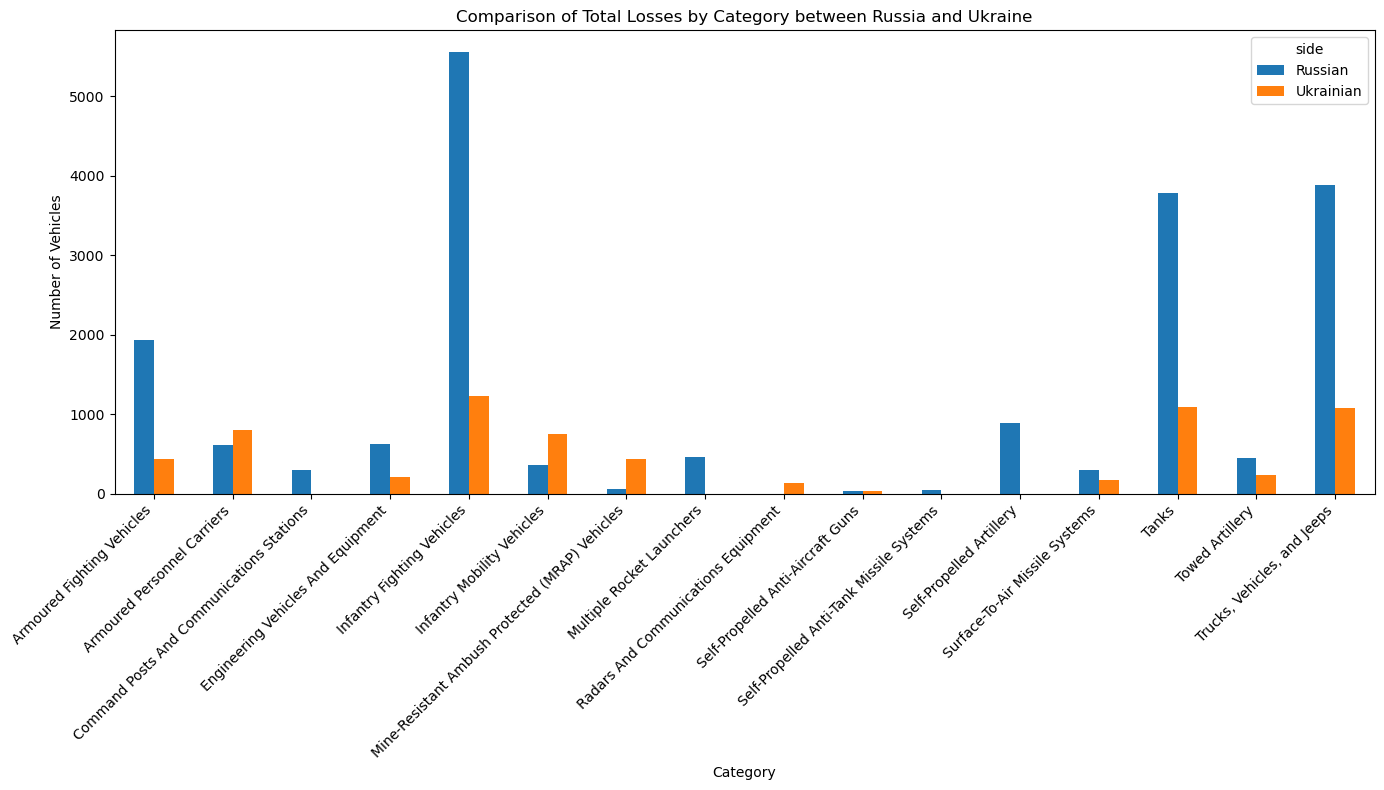

<Figure size 1200x800 with 0 Axes>

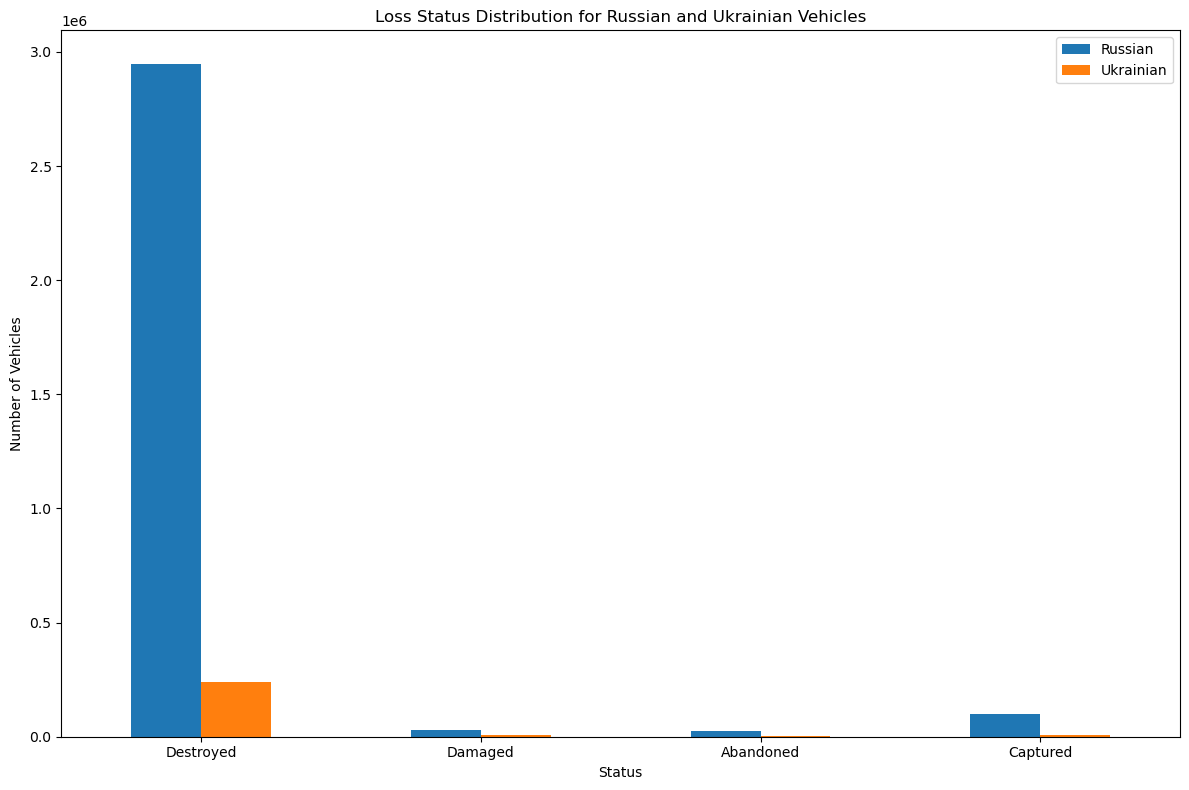

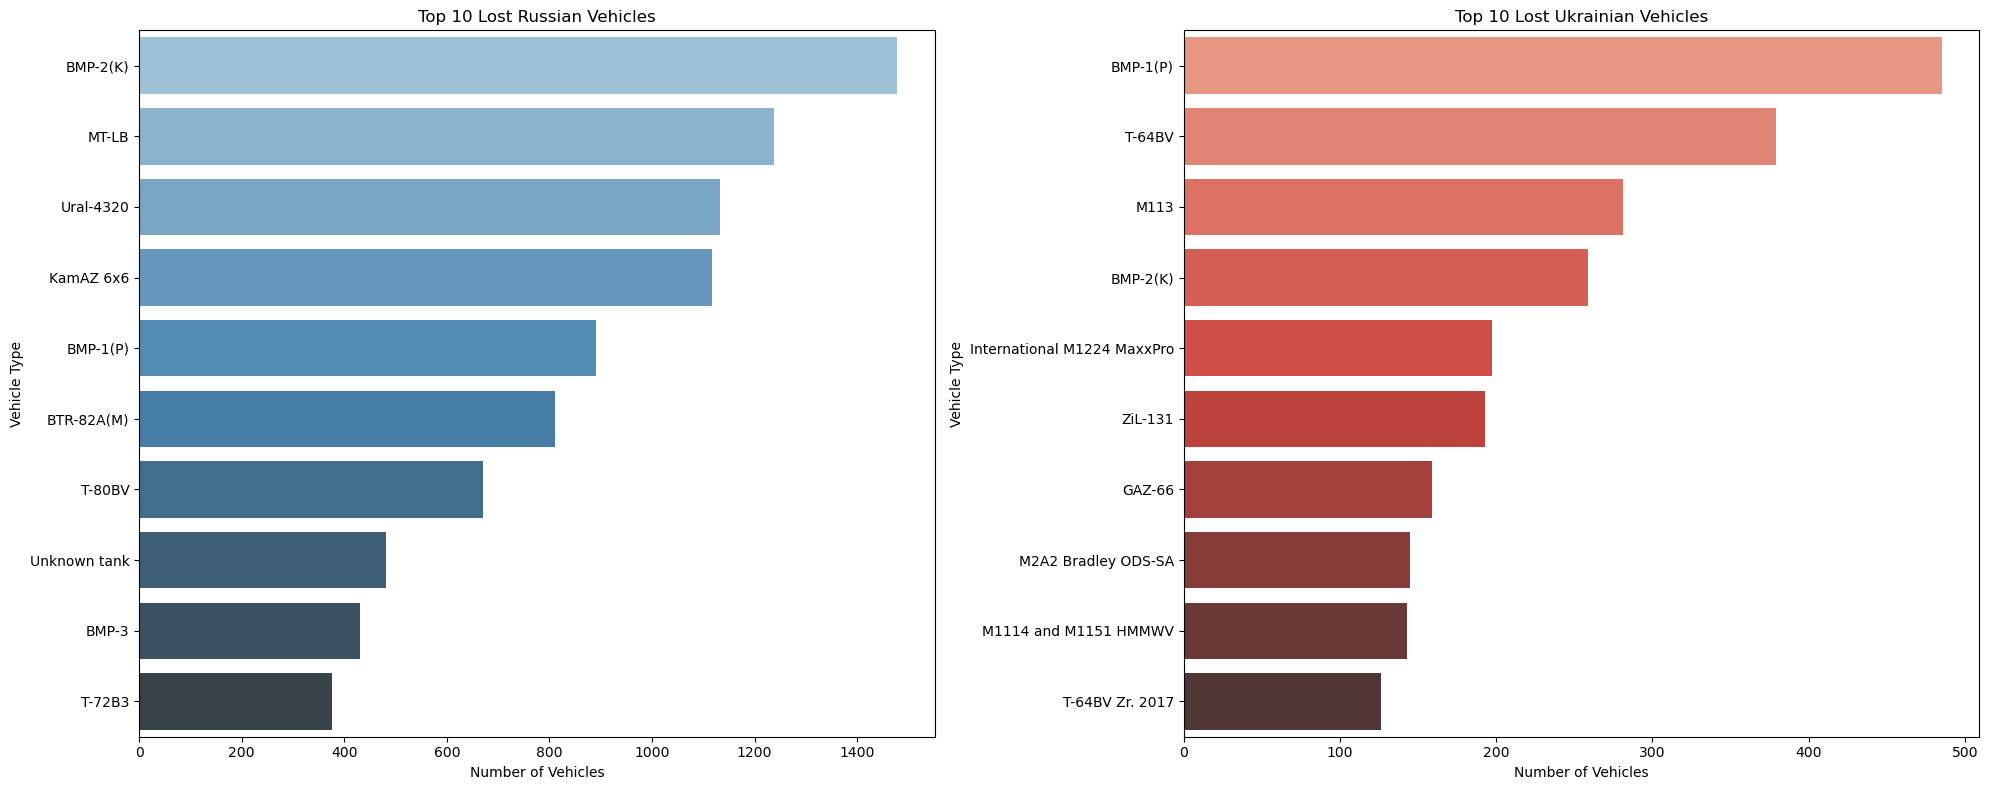

<Figure size 1000x600 with 0 Axes>

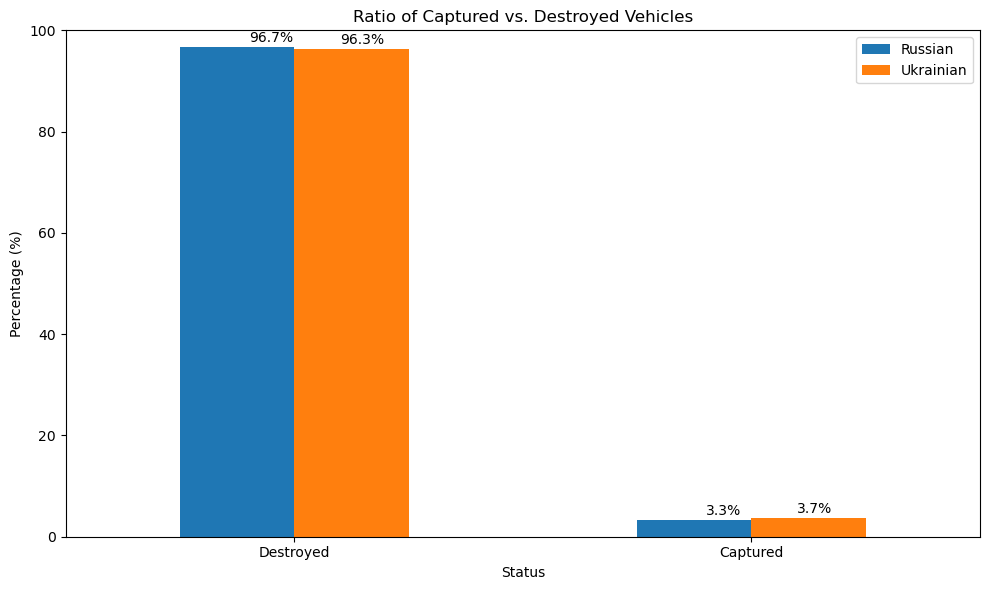

In [23]:

#Run all analyses
try:
    print("Starting data analysis...")
    
    total_losses = analyze_total_losses_by_category()
    status_distribution = analyze_loss_status_distribution()
    top_russian, top_ukrainian = analyze_top_vehicles_lost()
    captured_vs_destroyed = analyze_captured_vs_destroyed()
    
    #Save results to an Excel file
    with pd.ExcelWriter('analysis_war_ukraine.xlsx') as writer:
        total_losses.to_excel(writer, sheet_name='Total Losses by Category')
        status_distribution.to_excel(writer, sheet_name='Status Distribution')
        top_russian.to_excel(writer, sheet_name='Top Russian Vehicles')
        top_ukrainian.to_excel(writer, sheet_name='Top Ukrainian Vehicles')
        captured_vs_destroyed.to_excel(writer, sheet_name='Captured vs Destroyed')
    
    print("\nAnalysis Summary:")
    print(f"Total records processed: {len(combined_df)}")
    print(f"Russian vehicles analyzed: {len(russian_losses)}")
    print(f"Ukrainian vehicles analyzed: {len(ukrainian_losses)}")
    
    print("\nMain categories of Russian losses:")
    russian_categories = russian_losses.groupby('category')['vehicle_count'].sum().sort_values(ascending=False)
    for category, count in russian_categories.head(5).items():
        print(f"- {category}: {count}")
    
    print("\nMain categories of Ukrainian losses:")
    ukrainian_categories = ukrainian_losses.groupby('category')['vehicle_count'].sum().sort_values(ascending=False)
    for category, count in ukrainian_categories.head(5).items():
        print(f"- {category}: {count}")
    
    print("\nAnalysis complete!")
    
except Exception as e:
    print(f"Error during analysis: {e}")